In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import atecml.data
from tqdm import tqdm

class BasicModel(object):
    """Parent class of basic models"""
    def train(self, x_train, y_train, x_val, y_val):
        """return a trained model and eval metric o validation data"""
        pass
    
    def predict(self, model, x_test):
        """return the predicted result"""
        pass
    
    def get_oof(self, x_train, y_train, x_test, n_folds = 5):
        """K-fold stacking"""
        num_train, num_test = x_train.shape[0], x_test.shape[0]
        oof_train = np.zeros((num_train,)) 
        oof_test = np.zeros((num_test,))
        oof_test_all_fold = np.zeros((num_test, n_folds))
        aucs = []
        model_list = []
        
        for i in range(0,n_folds):
            
            val_index = DateFold[5] #始终用最后20%验证            
            train_index = list(all_list - DateFold[i])
                            
            print('{0} fold, train {1}, val {2}'.format(i, len(train_index), len(val_index)))
            x_tra, y_tra = x_train[train_index], y_train[train_index]
            x_val, y_val = x_train[val_index], y_train[val_index]
            
            #Over_sample
            #X_resampled, y_resampled = SMOTE().fit_sample(x_tra,y_tra)
            #model, auc = self.train(X_resampled, y_resampled, x_val, y_val)
            model, auc = self.train(x_tra, y_tra, x_val, y_val)
            aucs.append(auc)
            model_list.append(model)
            oof_train[val_index] = self.predict(model, x_val)
            oof_test_all_fold[:, i] = self.predict(model, x_test)
        oof_test = np.mean(oof_test_all_fold, axis=1)
        print('all aucs {0}, average {1}'.format(aucs, np.mean(aucs)))
        return oof_train, oof_test,model_list

import lightgbm as lgb
class LGBClassifier(BasicModel):
    '''
    ' 调参范围
    'num_leaves':range(35,65,5)
    'learning_rate':[0.01,0.05,0.1,0.3,0.5,0.7]
    'min_child_weight':range(1,6,2)
    'max_depth':range(3,10,2),
    'subsample':[i/10.0 for i in range(6,10)],正常直接设置为1
    'colsample_bytree':[i/10.0 for i in range(6,10)]，正常直接设置为1
    'reg_alpha','reg_lambda':[1e-5, 1e-2, 0.1, 1, 2,2.5,3]
    '''
    def __init__(self,boost_type,boost_round=1000,early_stop=100):
        self.num_boost_round = boost_round
        self.early_stopping_rounds = early_stop
        self.params = {
            'task': 'train',
            'boosting_type': boost_type,
            'colsample_bytree': 0.7,
            'learning_rate': 0.05,
            'max_bin': 255,
            'max_depth': 3,
            'metric': {'auc'},
            'min_child_samples': 800,
            'min_child_weight': 0.05,
            'min_split_gain': 0,
            'nthread': 40,
            'num_leaves': 31,
            'objective': 'binary',
            'reg_alpha': 1,
            'reg_lambda': 2,
            'is_unbalance':'true',
            #'scale_pos_weight': 99,
            'subsample': 0.85,
            'subsample_for_bin': 200000,
            'subsample_freq': 1,
            'use_missing': 'true',
            'verbose' : -1,
            }
        print(self.params)
        
    def train(self, x_train, y_train, x_val, y_val):
        print('train with lgb model')
        lgbtrain = lgb.Dataset(x_train, y_train)
        lgbval = lgb.Dataset(x_val, y_val)
        model = lgb.train(self.params, 
                          lgbtrain,
                          valid_sets=lgbval, 
                          verbose_eval = 50,
                          num_boost_round = self.num_boost_round,
                          early_stopping_rounds = self.early_stopping_rounds)
        return model, model.best_score['valid_0']['auc']
    
    def predict(self, model, x_test):
        print('test with lgb model')
        return model.predict(x_test, num_iteration=model.best_iteration)

def stack_layer1_result(X_train,rf_model_list,gbdt_model_list,dart_model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        rf_input_list = []
        for idx in tqdm(range(len(rf_model_list))):
            model = rf_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            rf_input_list.append(pd.DataFrame(_temp_df))
        rf_oof_predict= np.array(pd.concat(rf_input_list,ignore_index=True,axis=1).mean(axis=1))    
    
        gbdt_input_list = []
        for idx in tqdm(range(len(gbdt_model_list))):
            model = gbdt_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            gbdt_input_list.append(pd.DataFrame(_temp_df))
        gbdt_oof_predict= np.array(pd.concat(gbdt_input_list,ignore_index=True,axis=1).mean(axis=1))
        
        
        dart_input_list = []
        for idx in tqdm(range(len(dart_model_list))):
            model = dart_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            dart_input_list.append(pd.DataFrame(_temp_df))
        dart_oof_predict= np.array(pd.concat(dart_input_list,ignore_index=True,axis=1).mean(axis=1))
    
    input_predict = [rf_oof_predict, gbdt_oof_predict, dart_oof_predict] 
    stacked_predict = np.concatenate([f.reshape(-1, 1) for f in input_predict], axis=1)
    
    return stacked_predict    

In [3]:
train_df = pd.read_pickle('./train.dat')
val_df = atecml.data.load_test()


predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
DateFold={}
DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index)

In [4]:
target='Fraud'
x_train = np.array(train_df[predictors])
y_train = np.array(train_df[target])
x_test = np.array(val_df[predictors])
print(x_train.shape, y_train.shape, x_test.shape)

(994731, 163) (994731,) (500538, 163)


In [5]:
num_boost_round = 3000
num_early_stop = 100

In [6]:
# get output of first layer models and construct as input for the second layer          
rf_classifier = LGBClassifier(boost_type='rf',boost_round=num_boost_round,early_stop=num_early_stop)
rf_oof_train, rf_oof_test,rf_model_list = rf_classifier.get_oof(x_train, y_train, x_test)
print(rf_oof_train.shape, rf_oof_test.shape)  

{'max_bin': 255, 'metric': {'auc'}, 'is_unbalance': 'true', 'num_leaves': 31, 'subsample_for_bin': 200000, 'subsample': 0.85, 'max_depth': 3, 'min_child_weight': 0.05, 'min_child_samples': 800, 'reg_lambda': 2, 'subsample_freq': 1, 'task': 'train', 'nthread': 40, 'objective': 'binary', 'verbose': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'reg_alpha': 1, 'min_split_gain': 0, 'boosting_type': 'rf', 'use_missing': 'true'}
0 fold, train 831039, val 196810
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.956912
[100]	valid_0's auc: 0.956994
[150]	valid_0's auc: 0.957007
[200]	valid_0's auc: 0.956696
Early stopping, best iteration is:
[106]	valid_0's auc: 0.957279
test with lgb model
test with lgb model
1 fold, train 837649, val 196810
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.957077
[100]	valid_0's auc: 0.958667
[150]	valid_0's auc: 0.958558
Early stopping, best

In [7]:
gbdt_classifier = LGBClassifier(boost_type='gbdt',boost_round=num_boost_round,early_stop=num_early_stop)
gbdt_oof_train, gbdt_oof_test,gbdt_model_list = gbdt_classifier.get_oof(x_train, y_train, x_test)
print(gbdt_oof_train.shape, gbdt_oof_test.shape)  

dart_classifier = LGBClassifier(boost_type='dart',boost_round=num_boost_round,early_stop=num_early_stop)
dart_oof_train, dart_oof_test,dart_model_list = dart_classifier.get_oof(x_train, y_train, x_test)
print(dart_oof_train.shape, dart_oof_test.shape)    

{'max_bin': 255, 'metric': {'auc'}, 'is_unbalance': 'true', 'num_leaves': 31, 'subsample_for_bin': 200000, 'subsample': 0.85, 'max_depth': 3, 'min_child_weight': 0.05, 'min_child_samples': 800, 'reg_lambda': 2, 'subsample_freq': 1, 'task': 'train', 'nthread': 40, 'objective': 'binary', 'verbose': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'reg_alpha': 1, 'min_split_gain': 0, 'boosting_type': 'gbdt', 'use_missing': 'true'}
0 fold, train 831039, val 196810
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.973299
[100]	valid_0's auc: 0.977882
[150]	valid_0's auc: 0.980271
[200]	valid_0's auc: 0.981843
[250]	valid_0's auc: 0.982957
[300]	valid_0's auc: 0.983973
[350]	valid_0's auc: 0.984786
[400]	valid_0's auc: 0.985416
[450]	valid_0's auc: 0.985985
[500]	valid_0's auc: 0.986441
[550]	valid_0's auc: 0.986877
[600]	valid_0's auc: 0.987199
[650]	valid_0's auc: 0.987544
[700]	valid_0's auc: 0.987793
[750]	valid_0's auc: 0.988083

[2450]	valid_0's auc: 0.992347
[2500]	valid_0's auc: 0.992418
[2550]	valid_0's auc: 0.992504
[2600]	valid_0's auc: 0.992576
[2650]	valid_0's auc: 0.992635
[2700]	valid_0's auc: 0.992717
[2750]	valid_0's auc: 0.992784
[2800]	valid_0's auc: 0.992838
[2850]	valid_0's auc: 0.992901
[2900]	valid_0's auc: 0.992965
[2950]	valid_0's auc: 0.993023
[3000]	valid_0's auc: 0.993075
Did not meet early stopping. Best iteration is:
[3000]	valid_0's auc: 0.993075
test with lgb model
test with lgb model
4 fold, train 831094, val 196810
train with lgb model
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.971985
[100]	valid_0's auc: 0.976945
[150]	valid_0's auc: 0.979478
[200]	valid_0's auc: 0.981174
[250]	valid_0's auc: 0.98238
[300]	valid_0's auc: 0.983406
[350]	valid_0's auc: 0.984086
[400]	valid_0's auc: 0.984811
[450]	valid_0's auc: 0.985442
[500]	valid_0's auc: 0.985866
[550]	valid_0's auc: 0.986253
[600]	valid_0's auc: 0.986684
[650]	valid_0's auc: 0.987049
[700

[1400]	valid_0's auc: 0.986272
[1450]	valid_0's auc: 0.986378
[1500]	valid_0's auc: 0.986469
[1550]	valid_0's auc: 0.986599
[1600]	valid_0's auc: 0.986798
[1650]	valid_0's auc: 0.98696
[1700]	valid_0's auc: 0.987079
[1750]	valid_0's auc: 0.987204
[1800]	valid_0's auc: 0.987317
[1850]	valid_0's auc: 0.987486
[1900]	valid_0's auc: 0.987598
[1950]	valid_0's auc: 0.987689
[2000]	valid_0's auc: 0.987826
[2050]	valid_0's auc: 0.987937
[2100]	valid_0's auc: 0.988028
[2150]	valid_0's auc: 0.988107
[2200]	valid_0's auc: 0.988202
[2250]	valid_0's auc: 0.988316
[2300]	valid_0's auc: 0.988427
[2350]	valid_0's auc: 0.988505
[2400]	valid_0's auc: 0.98862
[2450]	valid_0's auc: 0.988744
[2500]	valid_0's auc: 0.988842
[2550]	valid_0's auc: 0.988944
[2600]	valid_0's auc: 0.989016
[2650]	valid_0's auc: 0.989077
[2700]	valid_0's auc: 0.989184
[2750]	valid_0's auc: 0.989253
[2800]	valid_0's auc: 0.989328
[2850]	valid_0's auc: 0.989377
[2900]	valid_0's auc: 0.989473
[2950]	valid_0's auc: 0.989535
[3000]	val

In [8]:
stacked_train = stack_layer1_result(x_train,rf_model_list,gbdt_model_list,dart_model_list)
stacked_test = stack_layer1_result(x_test,rf_model_list,gbdt_model_list,dart_model_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-02 20:51:17][Classification: Building Layer-1 Stack] Begin ...


  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-02 20:53:01][Classification: Building Layer-1 Stack] End   ...[Elapsed: 103.98s]
[2018-07-02 20:53:01][Classification: Building Layer-1 Stack] Begin ...


100%|██████████| 5/5 [00:21<00:00,  4.41s/it]

[2018-07-02 20:53:51][Classification: Building Layer-1 Stack] End   ...[Elapsed: 49.94s]


Ant-Score: 0.5691700960219479


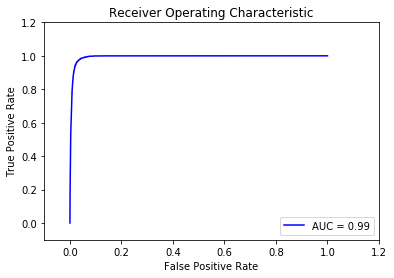

In [9]:
# use XGBOOST  as the model of the second layer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 nthread=40,
 seed=27)


# split for validation
n = int(stacked_train.shape[0] * 0.8)
x_tra, y_tra = stacked_train[:n], y_train[:n]
x_val, y_val = stacked_train[n:], y_train[n:]
model.fit(x_tra,y_tra)
y_pred = pd.DataFrame(model.predict_proba(x_val))[1]

_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,y_pred)

In [10]:
# predict on test data
final_model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=200,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 nthread=40,
 seed=27)


final_model.fit(stacked_train, y_train)
test_prediction = final_model.predict_proba(stacked_test)

result=pd.DataFrame()
result['id'] = val_df['id']
result['score'] = pd.DataFrame(test_prediction)[1]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfd92f62e8>]],
      dtype=object)

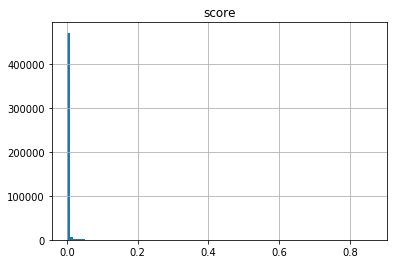

In [11]:
result.hist(bins=100)

In [12]:
len(result[result.score > 0.1])

13089

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfe401a9b0>]],
      dtype=object)

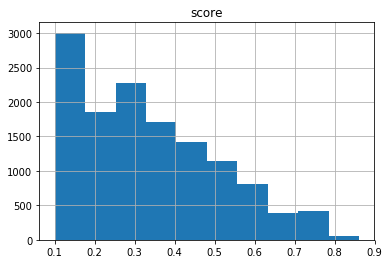

In [13]:
result[result.score > 0.1].hist()

In [14]:
result.to_csv('./submit_0702_night.csv',index=False)